# Preprocessing & patch extraction (notebook overview)

This notebook builds a preprocessing pipeline for images named like `img_*.png` (or other image extensions), with optional companion masks named like `mask_*.png`.

**What it does**
- Detects and removes *green “goo”* / marker artifacts using an HSV **core + shell** heuristic (plus a small dilation to catch fringes).
- Optionally *cleans* external masks by zeroing out regions marked as goo-safe/unsafe.
- Flags and optionally separates unusually-green images (“Shreks”) using a simple **green-pixel ratio**.
- Extracts **patches** (and matching mask patches) around connected components in the mask, with controls to limit patch count (stride, per-blob caps, IoU-based pruning).
- Optionally post-processes patches by **blurring background** and/or **applying mask patches** to zero out non-mask pixels.

**Naming conventions used throughout**
- Source images: `img_XXXX.*`
- External masks: `mask_XXXX.*`
- Goo-safe masks saved by goo removal: `goo_mask_XXXX.*` (white = safe)
- Patch images: `img_XXXX_pN.png`
- Patch masks: `mask_XXXX_pN.png`

Paths for inputs/outputs are configured in **Section 3**.


## **1. Import Libraries**

In [59]:

# Import necessary libraries
import os

# Set environment variables before importing module
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
from scipy import ndimage
from PIL import Image
# Import other libraries
import cv2
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import glob
from pathlib import Path
import shutil
import gc

plt.rc('font', size=14)
%matplotlib inline


## **2. Preprocessing**

- Preprocessing pipeline : 
    - Get Loaded Images
    - Create Goo Masks
    - Apply Goo Removal + Resizing
    - Discard Shrek Images
    - Apply the external Masks (optional)
    

### 2.1 Preprocessing Functions

#### 2.1.1 _get_smart_goo_mask

**Purpose**: Build a binary mask that marks *goo* (green artifact) pixels.

- **Input**: `img_bgr` — image as a NumPy array in **BGR** order (OpenCV default).
- **Output**: mask `uint8` where **255 = goo** and **0 = safe**.

**Method (high level)**
1. Convert image to HSV.
2. Threshold a strict **core** green range and a looser **shell** (halo) range.
3. Keep shell connected-components **only if they touch** the core mask.
4. Fill/clean blobs (drop tiny regions) and apply a **1‑pixel dilation** to catch anti-aliased fringes.

This helper is used by `remove_goo()` and (optionally) `apply_mask()`.


In [60]:
def _get_smart_goo_mask(img_bgr):
    """
    Internal helper to detect goo using Core & Shell logic + 1px Nudge.
    Returns a binary mask (White = Goo, Black = Safe).
    """
    # 1. Convert to HSV
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # 2. Define Ranges
    # CORE: Solid Green (Strict)
    core_lower = np.array([35, 100, 50])
    core_upper = np.array([85, 255, 255])
    
    # SHELL: Faint Halo (Loose/Transparent)
    shell_lower = np.array([30, 30, 30])
    shell_upper = np.array([95, 255, 255])

    # 3. Create initial masks
    mask_core = cv2.inRange(hsv, core_lower, core_upper)
    mask_shell = cv2.inRange(hsv, shell_lower, shell_upper)

    # 4. Smart Combine (Connected Components)
    # Keep 'Shell' blobs ONLY if they touch 'Core' blobs
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_shell, connectivity=8)
    smart_mask = np.zeros_like(mask_core)

    for label_id in range(1, num_labels): # Skip background (0)
        blob_mask = (labels == label_id).astype(np.uint8) * 255
        
        # Check overlap with Core
        overlap = cv2.bitwise_and(blob_mask, mask_core)
        
        # If there is ANY overlap, keep the blob
        if cv2.countNonZero(overlap) > 0:
            smart_mask = cv2.bitwise_or(smart_mask, blob_mask)

    # 5. Fill Holes (in case the goo has shiny reflections)
    contours, _ = cv2.findContours(smart_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_filled_mask = np.zeros_like(smart_mask)
    for contour in contours:
        # Minimum area filter (200px) to remove tiny stray noise
        if cv2.contourArea(contour) > 200:
            cv2.drawContours(final_filled_mask, [contour], -1, (255), thickness=cv2.FILLED)

    # 6. The "1-Pixel Nudge"
    # Safely expand by 1 pixel to cover the final anti-aliased fringe
    kernel = np.ones((3, 3), np.uint8)
    final_expanded_mask = cv2.dilate(final_filled_mask, kernel, iterations=1)

    return final_expanded_mask



#### 2.1.2 remove_goo

**Purpose**: Iterate over a folder of images, optionally resize, and replace detected goo pixels with a solid background color.

- **Inputs**:
  - `input_dir`, `output_dir`
  - `target_size`: `(W, H)` in pixels, or `None` to keep original size
  - `remove_goo`: enable/disable goo replacement
  - `save_masks`: save a *goo-safe* mask alongside images
  - `replacement_color`: `(B, G, R)` fill color for goo regions
- **Outputs**:
  - Processed images written to `output_dir`
  - If `save_masks=True`: masks in `output_dir/goo_masks/` named `goo_mask_*` where **255 = safe** and **0 = goo**

**Notes**
- Goo detection is driven by `_get_smart_goo_mask()` (core+shell heuristic).
- Masks saved here are inverted (safe=white) because they’re typically used as “keep” masks later.


In [61]:
def remove_goo(input_dir, output_dir, target_size=(224, 224), remove_goo=True, save_masks=True, replacement_color=(0, 0, 0)):
    """
    Iterates through input_dir, finds 'img_xxxx', resizes them to target_size, 
    and saves the result to output_dir.
    If remove_goo is True, it replaces green pixels (using Smart Core/Shell logic) with replacement_color.
    replacement_color: Tuple of (B, G, R) values. Default is black (0, 0, 0).
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Extensions to look for
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    
    # 1. Gather all valid image files first
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir() 
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]
    
    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    # 2. Iterate with tqdm
    count = 0
    
    for file_path in tqdm(image_files, desc="Removing Goo from Images", unit="img"):
        output_path = output_dir / file_path.name
        
        if output_path.exists():
            # Skip silently
            continue

        img = cv2.imread(str(file_path))
        if img is None:
            continue
            
        if target_size is not None:
            img = cv2.resize(img, target_size)
            
        if remove_goo:
            # --- NEW SMART GOO LOGIC ---
            # Get the smart mask (White = Goo)
            goo_mask = _get_smart_goo_mask(img)
            
            # Invert Goo Mask (White = Safe)
            not_goo_mask = cv2.bitwise_not(goo_mask)
            
            # Apply Mask to keep safe areas (Goo areas become black/0)
            img_safe = cv2.bitwise_and(img, img, mask=not_goo_mask)
            
            # Create background with replacement color
            bg = np.full_like(img, replacement_color)
            
            # Keep background only where Goo is
            bg_goo = cv2.bitwise_and(bg, bg, mask=goo_mask)
            
            # Combine: Safe Image + Colored Goo Areas
            img = cv2.add(img_safe, bg_goo)

            if save_masks:
                # Save the mask (White = Safe/Tissue, Black = Goo)
                mask_name = file_path.name.replace('img_', 'goo_mask_', 1)
                mask_output_path = os.path.join(output_dir, "goo_masks", mask_name)
                Path(os.path.dirname(mask_output_path)).mkdir(parents=True, exist_ok=True)
                cv2.imwrite(str(mask_output_path), not_goo_mask)
            
        cv2.imwrite(str(output_path), img)
        count += 1

    print(f"Resizing complete. Processed {count} new images.")

#### 2.1.3 clean_and_save_masks

**Purpose**: Remove goo regions from *external* masks by AND-ing them with the goo-safe masks produced during `remove_goo()`.

- **Inputs**:
  - `goo_masks_dir`: folder containing `goo_mask_*.png` (white = safe)
  - `external_masks_dir`: folder containing original masks (typically `mask_*.png`)
  - `output_dir`: where cleaned masks are written
  - `target_size`: optional resize (nearest-neighbor)
- **Output**: cleaned masks in `output_dir` where pixels are white only if they were white in **both** masks.

**Why this exists**
If goo overlaps the region of interest, cleaning prevents those pixels from being treated as valid tissue/tumor during patch extraction.


In [62]:
def clean_and_save_masks(goo_masks_dir, external_masks_dir, output_dir, target_size=(224, 224)):
    """
    Loads goo masks (White=Safe) and original external masks.
    Removes goo areas from external masks and saves the cleaned versions.
    Skips processing if a cleaned mask already exists in the output directory.
    """
    goo_masks_dir = Path(goo_masks_dir)
    external_masks_dir = Path(external_masks_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    goo_mask_files = list(goo_masks_dir.glob('goo_mask_*.png'))
    
    if not goo_mask_files:
        print(f"No goo masks found in {goo_masks_dir}")
        return

    print(f"Found {len(goo_mask_files)} goo masks. Checking for existing and processing new masks...")

    processed_count = 0
    skipped_count = 0
    for goo_mask_path in tqdm(goo_mask_files, desc="Cleaning External Masks"):
        # Derive the corresponding output mask name
        mask_name = goo_mask_path.name.replace('goo_mask_', 'mask_', 1)
        output_path = output_dir / mask_name


        # Check if the cleaned mask already exists to skip reprocessing
        if output_path.exists():
            skipped_count += 1
            continue


        external_mask_path = external_masks_dir / mask_name
        
        if not external_mask_path.exists():
            # This part was commented out in the original, but it's good practice
            # to log when a corresponding file is missing.
            # tqdm.write(f"Warning: External mask not found for {goo_mask_path.name}")
            continue

        # Load masks
        goo_mask = cv2.imread(str(goo_mask_path), cv2.IMREAD_GRAYSCALE)
        external_mask = cv2.imread(str(external_mask_path), cv2.IMREAD_GRAYSCALE)

        if goo_mask is None or external_mask is None:
            tqdm.write(f"Warning: Could not read one of the masks for {mask_name}")
            continue

        # Resize external mask if a target size is specified
        if target_size is not None:
             external_mask = cv2.resize(external_mask, target_size, interpolation=cv2.INTER_NEAREST)
             # Ensure goo_mask also matches the target size
             if goo_mask.shape[:2] != (target_size[1], target_size[0]):
                 goo_mask = cv2.resize(goo_mask, target_size, interpolation=cv2.INTER_NEAREST)

        # Ensure masks are binary (0 or 255)
        _, external_mask = cv2.threshold(external_mask, 127, 255, cv2.THRESH_BINARY)
        _, goo_mask = cv2.threshold(goo_mask, 127, 255, cv2.THRESH_BINARY)

        # Combine masks: The resulting pixel is white only if it's white in BOTH masks.
        # This effectively removes "goo" areas from the "region of interest".
        cleaned_mask = cv2.bitwise_and(external_mask, goo_mask)

        # Save the final cleaned mask
        cv2.imwrite(str(output_path), cleaned_mask)
        processed_count += 1

    print("\nProcessing complete.")
    print(f"  - Cleaned and saved: {processed_count} masks to {output_dir}")
    if skipped_count > 0:
        print(f"  - Skipped: {skipped_count} masks that already existed.")

#### 2.1.4 apply_mask

**Purpose**: Apply a binary mask to an image and save the masked image (outside-mask pixels become 0/black).

- Loads the image (`image_path`) and the mask (`mask_path`, grayscale).
- Resizes to `target_size` (if not `None`) and thresholds the mask to binary.
- If `remove_goo=True`, it additionally removes goo pixels from the *kept* region using `_get_smart_goo_mask()`.
- Writes the masked image to `output_path`.

**Mask convention**
The final mask passed into `cv2.bitwise_and(..., mask=final_mask)` should be **255 = keep**, **0 = drop**.


In [63]:
def apply_mask(image_path, mask_path, output_path, target_size=(224, 224), remove_goo=True):
    """
    Loads an image and a mask. 
    If remove_goo is True, it subtracts green pixels (using Smart Core/Shell logic) 
    from the valid mask area. Resizes and saves the result.
    """
    # 1. Load Image
    img = cv2.imread(str(image_path))
    if img is None:
        tqdm.write(f"Error: Could not load image at {image_path}")
        return

    # 2. Load External Mask (Read as grayscale)
    mask = cv2.imread(str(mask_path), 0)
    if mask is None:
        tqdm.write(f"Error: Could not load mask at {mask_path}")
        return

    # 3. Resize both to target size
    if target_size is not None:
        img = cv2.resize(img, target_size)
        mask = cv2.resize(mask, target_size)

    # 4. Standardize External Mask (Binary 0 or 255)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Determine Final Mask
    if remove_goo:
        # --- NEW SMART GOO LOGIC ---
        # Get the smart mask (White = Goo)
        goo_mask = _get_smart_goo_mask(img)
        
        # Invert Goo Mask (White = Safe)
        not_goo_mask = cv2.bitwise_not(goo_mask)
        
        # Combine: Must be Tissue (binary_mask) AND Safe (not_goo_mask)
        final_mask = cv2.bitwise_and(binary_mask, not_goo_mask)
    else:
        # --- ORIGINAL LOGIC ---
        final_mask = binary_mask

    # 6. Apply Final Mask
    # Areas outside the final mask become Black (0)
    masked_img = cv2.bitwise_and(img, img, mask=final_mask)

    # 7. Save result
    # Ensure output directory exists
    os.makedirs(os.path.dirname(str(output_path)), exist_ok=True)
    cv2.imwrite(str(output_path), masked_img)

#### 2.1.5 filter_bright_green_areas

**Purpose**: Detect bright/subtle green pixels in an image and return both a filtered image and the green mask.

- **Input**: `image` is expected in **RGB** with values in **[0, 1]** (float).
- **Outputs**:
  - `result_bgr`: image with detected-green regions removed (returned in **BGR** for OpenCV-friendly downstream use)
  - `combined_mask`: mask of detected green pixels (**non-zero = green**)

**How it works**
Uses HSV thresholding + morphology to catch both saturated “main green” and faint halo greens, then optionally dilates to remove edge artifacts.


In [64]:
def filter_bright_green_areas(image, lg_H=20, lg_S=45, lg_V=0, ug_H=84, ug_S=255, ug_V=255, dilate_iterations=2):
    """
    Filters out bright green areas from the input image with improved residual removal.
    
    Args:
        image: Input image in RGB format (0-1 range)
        lg_H, lg_S, lg_V: Lower bounds for HSV green detection
        ug_H, ug_S, ug_V: Upper bounds for HSV green detection
        dilate_iterations: Number of dilation iterations to expand mask (removes edge artifacts)
    """

    # Convert from RGB (0-1) to BGR (0-255) for OpenCV
    original_bgr = (image * 255).astype(np.uint8)[..., ::-1]

    # 1. Convert to HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2HSV)

    # 2. Define the "Bright Green" Range
    lower_green = (lg_H, lg_S, lg_V)
    upper_green = (ug_H, ug_S, ug_V)

    # Create the initial mask
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # 3. Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # OPEN: Remove small noise
    clean_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # DILATE: Expand the mask to catch edge artifacts and residuals
    # This ensures we remove green pixels at the boundaries
    if dilate_iterations > 0:
        clean_mask = cv2.dilate(clean_mask, kernel, iterations=dilate_iterations)

    # 4. Additional step: Detect any remaining green-ish pixels
    # Create a more aggressive mask for subtle green tones
    lower_green_subtle = (max(0, lg_H - 10), max(0, lg_S - 10), 0)
    upper_green_subtle = (min(180, ug_H + 10), 255, 255)
    subtle_mask = cv2.inRange(hsv, lower_green_subtle, upper_green_subtle)
    
    # Only keep subtle green pixels that are near the main green area
    subtle_mask = cv2.morphologyEx(subtle_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Combine masks
    combined_mask = cv2.bitwise_or(clean_mask, subtle_mask)

    # 5. Invert mask to keep the useful parts
    mask_inv = cv2.bitwise_not(combined_mask)

    # 6. Apply the mask
    result_bgr = cv2.bitwise_and(original_bgr, original_bgr, mask=mask_inv)

    return result_bgr, combined_mask

#### 2.1.6 analyze_dataset_for_shreks 

**Purpose**: Scan a directory and classify images as **“Shrek”** vs **“Tissue”** based on how much green is present.

- Reads `img_*.png` from `directory`
- Uses `filter_bright_green_areas()` to get a green mask
- Computes `ratio = green_pixels / total_pixels`
- Returns two lists of dicts: `shrek_images` and `tissue_images` (each entry includes `path`, `name`, `ratio`, and `mask`)

**Tip**
Tune `ratio_threshold` based on a histogram/scatter plot of ratios (see `process_classification_results()`).


In [65]:
def analyze_dataset_for_shreks(directory, shrek_dir, ratio_threshold=0.0125, expected_count=150):
    """
    Analyzes images in a directory to classify them as "shrek" or "tissue".

    If the target shrek_dir already exists and contains the expected_count of images,
    this function will skip the analysis to save time.

    Args:
        directory (str): The source directory containing images to analyze.
        shrek_dir (str): The target directory where "shrek" images are saved.
                         This is used to check if processing can be skipped.
        ratio_threshold (float): The threshold for green pixel ratio to be classified as "shrek".
        expected_count (int): The number of images expected in shrek_dir to skip processing.

    Returns:
        tuple: A tuple containing two lists: (shrek_images, tissue_images).
               Returns ([], []) if processing is skipped.
    """
    # --- Start of new implementation ---
    shrek_dir_path = Path(shrek_dir)
    if shrek_dir_path.is_dir():
        # Count image files (e.g., .png, .jpg) in the shrek directory
        num_existing_images = len(list(shrek_dir_path.glob('img_*.png')))
        
        if num_existing_images == expected_count:
            print(f"'{shrek_dir}' already contains exactly {expected_count} images. Skipping analysis.")
            return [], [] # Return empty lists as the analysis is skipped
    # --- End of new implementation ---

    shrek_images = []
    tissue_images = []
    
    image_files = glob.glob(os.path.join(directory, 'img_*.png'))
    print(f"Found {len(image_files)} images in '{directory}'. Analyzing for 'Shreks'...")

    for f in tqdm(image_files, desc="Analyzing for Shreks"):
        try:
            img = cv2.imread(f)
            if img is None: continue
            
            img_rgb_norm = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            
            # This function call is part of your original code
            result_bgr, mask = filter_bright_green_areas(img_rgb_norm)
            
            total_pixels = img.shape[0] * img.shape[1]
            green_pixels = np.count_nonzero(mask)
            ratio = green_pixels / total_pixels
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            entry = {
                'name': os.path.basename(f), 
                'path': f,
                'img': img_rgb, 
                'ratio': ratio,
                'mask': mask
            }

            if ratio > ratio_threshold:
                shrek_images.append(entry)
            else:
                tissue_images.append(entry)
                
        except Exception as e:
            print(f"Skipping {f}: {e}")

    return shrek_images, tissue_images

#### 2.1.8 process_classification_results

**Purpose**: Materialize the “Shrek” vs “Tissue” split on disk (and optionally visualize the split).

- Copies files into `shrek_dir` and `tissue_dir` (skips if already present).
- If `visualize=True`, shows:
  - a 2×2 sample grid (2 shreks + 2 tissues)
  - a scatter plot of per-image green ratios with a threshold line

This is useful for **threshold tuning** and for sanity-checking misclassifications.


In [66]:
def process_classification_results(shrek_list, tissue_list, shrek_dir, tissue_dir, threshold, visualize = True):
    """
    Saves classified images to respective directories and visualizes the results.
    
    Args:
        shrek_list (list): List of dicts containing Shrek image data.
        tissue_list (list): List of dicts containing Tissue image data.
        shrek_dir (str): Path to save Shrek images.
        tissue_dir (str): Path to save Tissue images.
        threshold (float): The green ratio threshold used for classification.
    """
    
    # 1. Print Summary
    print(f"Classified {len(shrek_list)} as Shrek")
    print(f"Classified {len(tissue_list)} as Tissue")

    # Ensure directories exist
    os.makedirs(shrek_dir, exist_ok=True)
    os.makedirs(tissue_dir, exist_ok=True)

    # 2. Save Shrek images
    print(f"Saving {len(shrek_list)} Shrek images to {shrek_dir}...")
    for item in tqdm(shrek_list, desc="Saving Shrek Images"):
        dest_path = os.path.join(shrek_dir, item['name'])
        
        # Check if file exists to prevent overwriting
        if os.path.exists(dest_path):
            continue

        try:
            shutil.copy2(item['path'], dest_path)
        except Exception as e:
            print(f"Error copying {item['name']} to shrek folder: {e}")

    # 3. Save Tissue images
    print(f"Saving {len(tissue_list)} Tissue images to {tissue_dir}...")
    for item in tqdm(tissue_list, desc="Saving Tissue Images"):
        dest_path = os.path.join(tissue_dir, item['name'])
        
        # Check if file exists to prevent overwriting
        if os.path.exists(dest_path):
            continue

        try:
            shutil.copy2(item['path'], dest_path)
        except Exception as e:
            print(f"Error copying {item['name']} to tissue folder: {e}")
    if visualize == True:
        # 4. Visualize Examples (2x2 Grid)
        if len(shrek_list) >= 2 and len(tissue_list) >= 2:
            fig_ex, axes = plt.subplots(2, 2, figsize=(12, 10))
            fig_ex.suptitle(f"Classification Results (Threshold: {threshold:.1%})", fontsize=16)

            def show_img(ax, item, label):
                ax.imshow(item['img'])
                # Show the Green Ratio in the title so you can see WHY it was classified
                ax.set_title(f"{label}\n{item['name']}\nGreen Pixels: {item['ratio']:.2%}")
                ax.axis('off')

            # Row 1: Detected Shrek
            show_img(axes[0, 0], shrek_list[0], "Detected Shrek")
            show_img(axes[0, 1], shrek_list[1], "Detected Shrek")

            # Row 2: Detected Tissue
            show_img(axes[1, 0], tissue_list[0], "Detected Tissue")
            show_img(axes[1, 1], tissue_list[1], "Detected Tissue")

            plt.tight_layout()
            plt.show()
        else:
            print("Not enough images in one or both classes to generate 2x2 sample grid.")

        # 5. Plot Scatter Distribution for Tuning
        shrek_ratios = [x['ratio'] for x in shrek_list]
        tissue_ratios = [x['ratio'] for x in tissue_list]

        plt.figure(figsize=(12, 6))

        # Plot Tissue points (Blue)
        plt.scatter(range(len(tissue_ratios)), tissue_ratios, color='blue', alpha=0.6, label='Classified as Tissue')

        # Plot Shrek points (Green) - Shifted on x-axis to be distinct
        # We shift the x-axis index for Shrek so they appear after the tissue points
        plt.scatter(range(len(tissue_ratios), len(tissue_ratios) + len(shrek_ratios)), shrek_ratios, color='green', alpha=0.6, label='Classified as Shrek')

        # Draw the Threshold Line
        plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.1%})')

        plt.title('Green Pixel Ratio per Image', fontsize=14)
        plt.ylabel('Ratio of Green Pixels (0.0 - 1.0)')
        plt.xlabel('Image Index')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("Shrek removal visulization OFF.")

# --- Example Usage ---
# shrek_list, tissue_list = analyze_dataset(DATASET_PATH) # Assuming this runs before
# process_classification_results(shrek_list, tissue_list, SHREK_DIR, TISSUE_DIR, RATIO_THRESHOLD)

#### 2.1.9 copy_masks

**Purpose**: Copy mask files corresponding to a list of image filenames.

- Converts each `img_*.png` → `mask_*.png` by prefix replacement.
- Copies from `masks_dir` to `output_dir`.

**Assumption**
Your mask filenames follow the same ID as the images (only the `img_` / `mask_` prefix differs).


In [67]:
def copy_masks(image_list, masks_dir, output_dir):
    image_names = image_list
    mask_names = [name.replace('img_', 'mask_', 1) for name in image_names]

    for mask_name in tqdm(mask_names, desc="Copying Masks"):
        src_path = os.path.join(masks_dir, mask_name)
        dst_path = os.path.join(output_dir, mask_name)
        shutil.copy(src_path, dst_path)
    
    return

#### 2.1.10 extract_smart_patches

**Purpose**: Extract patch crops around connected components (“blobs”) in a mask, while controlling patch count.

**Inputs (common)**
- `img_path`, `mask_path`
- `patch_size`, `stride`
- `threshold`: minimum mask/tumor ratio inside a patch to keep it
- `dilate_iterations`: expands blobs so patch bboxes cover borders

**Patch-count controls**
- `max_patches_per_blob`: cap patches kept per blob
- `iou_thresh`: NMS-style pruning to reduce near-duplicates
- `pad_fraction`: optional bbox padding around each blob

**Returns**
`(kept_patches, kept_coords, img_arr, mask_arr)` where `kept_coords` are `(x, y)` top-left patch coordinates.
#### 2.1.10 extract_smart_patches

In [68]:
def extract_smart_patches(
    img_path,
    mask_path,
    patch_size=224,
    stride=224,
    threshold=0.01,
    dilate_iterations=15,
    enforce_blob_overlap=True,

    # --- patch count controls ---
    pad_fraction=0.0,          # 0.0 = no bbox padding (recommended to reduce count)
    max_patches_per_blob=None,    # cap kept patches per blob
    iou_thresh=0.5,           # NMS: reject if overlaps too much with already kept patches
    score_mode="mask_ratio", # "tumor_pixels" or "mask_ratio"
):
    """
    Extract patches over tumor blobs, with multi-patch coverage for big blobs BUT controlled patch count.

    - Dilate + label to form blobs
    - Tile candidate patches over each blob bbox (optionally padded)
    - Filter by tumor ratio + tissue ratio
    - Optional: ensure each patch overlaps its specific blob label
    - Reduce redundancy via NMS (IoU) and cap max_patches_per_blob
    """

    # --- Load images ---
    try:
        img = Image.open(img_path).convert("RGB")
    except FileNotFoundError:
        if img_path.endswith(".png"):
            img = Image.open(img_path.replace(".png", ".jpg")).convert("RGB")
        else:
            raise

    mask = Image.open(mask_path).convert("L")

    img_arr = np.array(img)
    mask_arr = np.array(mask)

    # Normalize mask to 0..255 for consistent thresholding
    mask_check = (mask_arr * 255) if mask_arr.max() <= 1 else mask_arr

    h, w = img_arr.shape[:2]

    if isinstance(patch_size, int):
        ph, pw = patch_size, patch_size
    else:
        ph, pw = patch_size

    if isinstance(stride, int):
        sh, sw = stride, stride
    else:
        sh, sw = stride

    # --- helpers ---
    def clamp_start(v, max_v, p):
        return max(0, min(int(v), int(max_v - p)))

    def make_starts(min_v, max_v, p, s, limit):
        """Cover [min_v, max_v) with windows of size p using stride s, include endpoint."""
        min_v = int(min_v)
        max_v = int(max_v)
        if max_v - min_v <= p:
            mid = (min_v + max_v) // 2 - p // 2
            return [clamp_start(mid, limit, p)]
        starts = list(range(min_v, max_v - p + 1, s))
        end = max_v - p
        if not starts:
            starts = [end]
        elif starts[-1] != end:
            starts.append(end)
        return [clamp_start(v, limit, p) for v in starts]

    def iou_xywh(a, b):
        """IoU for boxes in (x, y, w, h)."""
        ax, ay, aw, ah = a
        bx, by, bw, bh = b
        ax2, ay2 = ax + aw, ay + ah
        bx2, by2 = bx + bw, by + bh

        ix1, iy1 = max(ax, bx), max(ay, by)
        ix2, iy2 = min(ax2, bx2), min(ay2, by2)
        iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
        inter = iw * ih
        if inter == 0:
            return 0.0
        union = aw * ah + bw * bh - inter
        return inter / union

    # --- grouping: dilate + label ---
    dilated_mask = ndimage.binary_dilation(mask_check > 128, iterations=dilate_iterations)
    labeled_mask, num_features = ndimage.label(dilated_mask)
    objects = ndimage.find_objects(labeled_mask)


    kept_patches = []
    kept_coords = []
    kept_xy = set()  # avoid duplicates across blobs

    # --- per blob: make candidates, score, NMS, cap ---
    for i, slice_obj in enumerate(objects):
        if slice_obj is None:
            continue

        label_id = i + 1
        y_slice, x_slice = slice_obj
        y_min, y_max = y_slice.start, y_slice.stop
        x_min, x_max = x_slice.start, x_slice.stop

        # bbox padding control (pad_fraction=0.0 keeps tight bbox)
        pad_y = int(ph * pad_fraction)
        pad_x = int(pw * pad_fraction)

        y0 = max(0, y_min - pad_y)
        y1 = min(h, y_max + pad_y)
        x0 = max(0, x_min - pad_x)
        x1 = min(w, x_max + pad_x)

        y_starts = make_starts(y0, y1, ph, sh, h)
        x_starts = make_starts(x0, x1, pw, sw, w)

        candidates = []
        for y in y_starts:
            for x in x_starts:
                # ensure patch is for this blob (optional)
                if enforce_blob_overlap:
                    lbl_patch = labeled_mask[y:y + ph, x:x + pw]
                    if not np.any(lbl_patch == label_id):
                        continue

                img_patch = img_arr[y:y + ph, x:x + pw]
                mask_patch = mask_check[y:y + ph, x:x + pw]

                # tissue ratio (avoid mostly background)
                img_gray = np.mean(img_patch, axis=2)
                tissue_ratio = np.sum(img_gray < 235) / (ph * pw)
                if tissue_ratio <= 0.15:
                    continue

                # tumor ratio threshold
                tumor_pixels = int(np.sum(mask_patch > 128))
                mask_ratio = tumor_pixels / (ph * pw)
                if mask_ratio < threshold:
                    continue

                # score for ranking (higher = keep first)
                if score_mode == "mask_ratio":
                    score = float(mask_ratio)
                else:
                    score = float(tumor_pixels)  # default: prioritize most tumor content

                candidates.append((score, x, y))

        if not candidates:
            continue

        # sort best-first
        candidates.sort(key=lambda t: t[0], reverse=True)

        # greedy NMS within this blob + cap
        selected_boxes = []
        selected = 0

        for score, x, y in candidates:
            if (x, y) in kept_xy:
                continue

            box = (x, y, pw, ph)

            if iou_thresh is not None and selected_boxes:
                too_much_overlap = any(iou_xywh(box, b) >= iou_thresh for b in selected_boxes)
                if too_much_overlap:
                    continue

            # accept
            kept_patches.append(img_arr[y:y + ph, x:x + pw])
            kept_coords.append((x, y))
            kept_xy.add((x, y))
            selected_boxes.append(box)
            selected += 1

            if max_patches_per_blob is not None and selected >= max_patches_per_blob:
                break

    return kept_patches, kept_coords, img_arr, mask_arr

#### 2.1.11 create_patches_dataset

**Purpose**: Batch driver around `extract_smart_patches()` that writes a patch-level dataset to disk.

For each source image in `input_dir`:
- Locates the matching mask in `mask_dir` (`img_XXXX` → `mask_XXXX`)
- Extracts patches + coordinates
- Saves:
  - image patches into `output_dir/`
  - corresponding mask patches into `output_dir/masks/`

**Skip behavior**
If patches for a given source image already exist in the output folder, the image is skipped to avoid rework.


In [69]:
def create_patches_dataset(input_dir, output_dir, mask_dir, 
                           threshold=0.01, 
                           patch_size=224, 
                           stride=224,
                           iou_thresh=0.5, 
                           dilate_iterations=15, 
                           max_patches_per_blob=10):
    """
    Iterates over images in input_dir, finds corresponding masks in mask_dir,
    extracts smart patches, and saves them to output_dir.
    Also saves corresponding mask patches to a 'masks' subdirectory.

    This function will skip processing for any source image if its corresponding
    patches are already found in the output directory.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    mask_dir = Path(mask_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Create subdirectory for mask patches
    masks_output_dir = output_dir / "masks"
    masks_output_dir.mkdir(parents=True, exist_ok=True)

    # Filter for image files
    image_files = sorted([
        f for f in input_dir.iterdir()
        if f.name.startswith('img_') and f.suffix.lower() in {'.png', '.jpg', '.jpeg'}
    ])

    total_patches_saved = 0
    images_processed = 0
    images_skipped = 0
    
    print(f"Starting patch extraction from {input_dir} to {output_dir}...")
    print(f"Found {len(image_files)} source images.")

    for source_image_path in tqdm(image_files, desc="Processing Images"):
        base_name = source_image_path.stem

        # --- CHECK FOR EXISTING PATCHES ---
        # Check if any patch file for this image already exists.
        # We use glob to find files matching the pattern like 'img_xxxx_p*.png'.
        # next() with a default value is an efficient way to check for existence
        # without listing all files.
        if next(output_dir.glob(f"{base_name}_p*.png"), None):
            # tqdm.write(f"Skipping {source_image_path.name}, patches already exist.")
            images_skipped += 1
            continue

        # Construct mask filename (e.g., 'img_xxxx.png' -> 'mask_xxxx.png')
        mask_name = source_image_path.name.replace('img_', 'mask_', 1)
        mask_path = mask_dir / mask_name

        # Fallback if mask has a different extension or wasn't found initially
        if not mask_path.exists():
             mask_path = mask_dir / (base_name.replace('img_', 'mask_', 1) + ".png")

        if mask_path.exists():
            # Extract patches
            patches, coords, _, mask_arr = extract_smart_patches(
                str(source_image_path),
                str(mask_path),
                patch_size=patch_size,
                stride=stride,
                threshold=threshold,
                dilate_iterations=dilate_iterations,
                iou_thresh=iou_thresh,
                max_patches_per_blob=max_patches_per_blob,  # Example cap

            )

            if not patches:
                continue

            # Save each patch and corresponding mask patch
            for i, (patch_array, (x, y)) in enumerate(zip(patches, coords)):
                # Save image patch
                patch_img = Image.fromarray(patch_array)
                save_name = f"{base_name}_p{i}.png"
                patch_img.save(output_dir / save_name)
                
                # Extract and save mask patch
                if isinstance(patch_size, int):
                    ph, pw = patch_size, patch_size
                else:
                    ph, pw = patch_size
                    
                mask_patch = mask_arr[y:y+ph, x:x+pw]
                mask_patch_img = Image.fromarray(mask_patch)
                mask_save_name = f"mask_{base_name.replace('img_', '')}_p{i}.png"
                mask_patch_img.save(masks_output_dir / mask_save_name)
            
            total_patches_saved += len(patches)
            images_processed += 1
        else:
            tqdm.write(f"Warning: Mask not found for {source_image_path.name}")

    print("\n--- Extraction Summary ---")
    print(f"Images Processed: {images_processed}")
    print(f"Images Skipped:   {images_skipped}")
    print(f"Total Patches Saved in this run: {total_patches_saved}")
    print(f"Patches are located in: {output_dir}")
    print(f"Mask patches are located in: {masks_output_dir}")

#### 2.1.12 batch_blur

**Purpose**: Apply a “blur outside mask” effect in bulk via `apply_blur_batch()`.

- Keeps pixels where the mask is 255 (intact)
- Applies Gaussian blur to the complement (mask=0)
- Writes results to `output_dir`

**Important assumption**
`apply_blur_batch()` currently assumes **mask filename == image filename**.
If your masks are named `mask_*.png` while images are `img_*.png`, you’ll need to map names (or use `apply_patch_masks_to_images()` for patch masking).


In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

def apply_blur_batch(images_dir, masks_dir, output_dir, blur_strength=(51, 51)):
    """
    Applies the blur mask logic to all images in a directory.
    Assumes mask filenames match image filenames.
    """
    # 1. Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")

    # 2. Iterate through files in the images directory
    supported_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    files = [f for f in os.listdir(images_dir) if f.lower().endswith(supported_extensions)]

    print(f"Found {len(files)} images to process.")

    for filename in tqdm(files, desc="Processing images", unit="img"):
        img_path = os.path.join(images_dir, filename)
        mask_filename = filename.replace('img_', 'mask_', 1) if filename.startswith('img_') else filename
        mask_path = os.path.join(masks_dir, mask_filename)
        output_path = os.path.join(output_dir, filename)

        # 3. Validation
        if not os.path.exists(mask_path):
            print(f"Skipping {filename}: No corresponding mask found at {mask_path}")
            continue

        # 4. Load images
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, 0) # Load mask as grayscale

        if img is None or mask is None:
            print(f"Error: Could not load data for {filename}")
            continue

        # 5. Resize mask if dimensions don't match
        if img.shape[:2] != mask.shape:
            # print(f"Resizing mask for {filename}")
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

        # 6. Apply Blur Logic
        blurred_img = cv2.GaussianBlur(img, blur_strength, 0)
        
        # Ensure mask is binary: White (255) = Intact, Black (0) = Blurred
        _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        # Region A: Intact (where mask is 255)
        intact_parts = cv2.bitwise_and(img, img, mask=binary_mask)

        # Region B: Blurred (where mask is 0)
        mask_inverted = cv2.bitwise_not(binary_mask)
        blurred_parts = cv2.bitwise_and(blurred_img, blurred_img, mask=mask_inverted)

        # Combine
        result = cv2.add(intact_parts, blurred_parts)

        # 7. Save Result
        cv2.imwrite(output_path, result)


#### 2.1.13 apply_patch_masks_to_images

**Purpose**: Apply each patch’s binary mask to its corresponding image patch (pixel-wise AND), producing *masked patch images*.

- **Inputs**:
  - `patches_dir`: folder containing patch images like `img_*_p*.png`
  - `masks_dir`: folder containing patch masks like `mask_*_p*.png` (defaults to `patches_dir/masks`)
  - `output_dir`: where masked patches are written (defaults to `patches_dir/masked`)
- **How matching works**: for each `img_...` patch, it looks for the corresponding `mask_...` patch by replacing the `img_` prefix with `mask_`.

This is often the easiest way to ensure that only the ROI remains in each patch before training/inference.


In [71]:
def apply_patch_masks_to_images(patches_dir, masks_dir=None, output_dir=None):
    """Apply mask patches to image patches and save masked outputs.
    Args:
        patches_dir: directory with img_*_p*.png
        masks_dir: directory with mask_*_p*.png (default: patches_dir / 'masks')
        output_dir: destination for masked patches (default: patches_dir / 'masked')
    """
    patches_dir = Path(patches_dir)
    masks_dir = Path(masks_dir) if masks_dir else patches_dir / "masks"
    output_dir = Path(output_dir) if output_dir else patches_dir / "masked"
    output_dir.mkdir(parents=True, exist_ok=True)

    patch_files = sorted(patches_dir.glob("img_*_p*.png"))
    if not patch_files:
        print(f"No patch images found in {patches_dir}")
        return

    applied, skipped = 0, 0
    for patch_path in tqdm(patch_files, desc="Applying mask patches"):
        mask_name = patch_path.stem.replace("img_", "mask_", 1) + patch_path.suffix
        mask_path = masks_dir / mask_name
        out_path = output_dir / patch_path.name

        if out_path.exists():
            skipped += 1
            continue
        if not mask_path.exists():
            tqdm.write(f"Mask not found for {patch_path.name}")
            continue

        img = np.array(Image.open(patch_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        if mask.shape[:2] != img.shape[:2]:
            mask = np.array(Image.open(mask_path).convert("L").resize((img.shape[1], img.shape[0]), Image.NEAREST))

        mask_bin = (mask > 127).astype(np.uint8)
        masked = cv2.bitwise_and(img, img, mask=mask_bin)
        Image.fromarray(masked).save(out_path)
        applied += 1

    print(f"Applied masks to {applied} patches. Skipped {skipped} existing outputs. Results in: {output_dir}")

## **2.5 Visualization Functions**

In [72]:
def visualize_smart_goo_results(img_bgr):
    """
    Visualizes the intermediate steps and final result of the _get_smart_goo_mask function.
    
    Args:
        img_bgr: Input image in BGR format.
    """
    # --- 1. Re-run intermediate steps for visualization purposes ---
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    
    # Define the same ranges as the main function
    core_lower = np.array([35, 100, 50])
    core_upper = np.array([85, 255, 255])
    shell_lower = np.array([30, 30, 30])
    shell_upper = np.array([95, 255, 255])

    # Generate raw intermediate masks
    mask_core = cv2.inRange(hsv, core_lower, core_upper)
    mask_shell = cv2.inRange(hsv, shell_lower, shell_upper)
    
    # Get the actual final result from your function
    final_mask = _get_smart_goo_mask(img_bgr)

    # --- 2. Create an Overlay for Verification ---
    # Create a red overlay to highlight exactly what was detected
    overlay = img_bgr.copy()
    # Paint detected pixels bright red
    overlay[final_mask == 255] = [0, 0, 255] 
    # Blend it with the original (Transparency)
    img_with_overlay = cv2.addWeighted(img_bgr, 0.7, overlay, 0.3, 0)

    # --- 3. Plotting with Matplotlib ---
    # Convert BGR to RGB for correct color display in matplotlib
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_overlay_rgb = cv2.cvtColor(img_with_overlay, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(18, 10))

    # Plot A: Original
    plt.subplot(2, 3, 1)
    plt.imshow(img_rgb)
    plt.title("1. Original Image")
    plt.axis("off")

    # Plot B: Core Mask (Strict)
    plt.subplot(2, 3, 2)
    plt.imshow(mask_core, cmap='gray')
    plt.title("2. Core Mask (Strict)\n(Must exist to anchor the goo)")
    plt.axis("off")

    # Plot C: Shell Mask (Loose)
    plt.subplot(2, 3, 3)
    plt.imshow(mask_shell, cmap='gray')
    plt.title("3. Shell Mask (Loose)\n(Includes halo & noise)")
    plt.axis("off")

    # Plot D: Final Smart Mask
    plt.subplot(2, 3, 4)
    plt.imshow(final_mask, cmap='gray')
    plt.title("4. Final Smart Mask\n(Filtered via Connected Components)")
    plt.axis("off")

    # Plot E: Verification Overlay
    plt.subplot(2, 3, 5)
    plt.imshow(img_overlay_rgb)
    plt.title("5. Overlay Verification\n(Red = Detected Area)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()



In [73]:
import random
def debug_batch_shreks(image_source, num_images=3, threshold=0.0125, random_seed=None):
    """
    Generates detailed classification dashboards for N images.

    Args:
        image_source (str or list): 
            - If str: Path to a directory (randomly samples N images).
            - If list: A list of file paths (processes the first N).
        num_images (int): Number of images to process.
        threshold (float): The Green Ratio threshold.
        random_seed (int): Seed for reproducible random sampling (optional).
    """
    
    # 1. Determine which files to process
    if isinstance(image_source, str):
        # It's a directory
        if not os.path.exists(image_source):
            print(f"Error: Directory '{image_source}' not found.")
            return
        all_files = glob.glob(os.path.join(image_source, "img_*.png")) # Adjust extension if needed
        if not all_files:
            print(f"No images found in {image_source}")
            return
            
        if random_seed is not None:
            random.seed(random_seed)
            
        # Sample N images (or take all if N > available)
        files_to_process = random.sample(all_files, min(len(all_files), num_images))
        print(f"--- Visualizing {len(files_to_process)} Random Samples from Directory ---")
        
    elif isinstance(image_source, list):
        # It's a specific list of files
        files_to_process = image_source[:num_images]
        print(f"--- Visualizing {len(files_to_process)} Specific Files ---")
    else:
        print("Error: image_source must be a directory path (str) or a list of file paths.")
        return

    # 2. Loop through and visualize each
    for i, img_path in enumerate(files_to_process):
        
        # --- LOGIC (Same as single debugger) ---
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read {img_path}")
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_rgb_norm = img_rgb.astype(np.float32) / 255.0

        # Attempt to run the filter function
        try:
            _, mask = filter_bright_green_areas(img_rgb_norm)
        except NameError:
            print("Error: 'filter_bright_green_areas' is not defined. Please define it.")
            return

        total_pixels = img.shape[0] * img.shape[1]
        green_pixels = np.count_nonzero(mask)
        ratio = green_pixels / total_pixels
        is_shrek = ratio > threshold
        
        # --- VISUALIZATION ---
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f"Sample {i+1} of {len(files_to_process)}: {os.path.basename(img_path)}", fontsize=14, fontweight='bold')

        # Plot A: Original
        axes[0].imshow(img_rgb)
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        # Plot B: Mask
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title(f"Green Mask (Pixels: {green_pixels})")
        axes[1].axis('off')

        # Plot C: Gauge
        verdict_color = 'red' if is_shrek else 'blue'
        verdict_text = "SHREK (Reject)" if is_shrek else "TISSUE (Keep)"
        
        axes[2].set_title("Decision Logic")
        axes[2].set_xlim(0, 1)
        axes[2].set_ylim(0, max(threshold * 2.5, ratio * 1.2)) # Dynamic height
        
        # Threshold Line
        axes[2].axhline(y=threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.2%}')
        
        # Ratio Bar
        bar_color = 'red' if is_shrek else 'green'
        axes[2].bar(0.5, ratio, width=0.4, color=bar_color, label=f'Ratio: {ratio:.2%}')
        axes[2].text(0.5, ratio + (threshold * 0.05), f"{ratio:.2%}", ha='center', fontweight='bold')
        
        # Verdict Box
        axes[2].text(0.5, max(threshold, ratio)/2, verdict_text, 
                     ha='center', va='center', fontsize=16, color='white', fontweight='bold',
                     bbox=dict(facecolor=verdict_color, alpha=0.8, boxstyle='round,pad=0.5'))
        
        axes[2].legend(loc='upper right')
        axes[2].set_xticks([])
        axes[2].set_ylabel("Green Ratio")

        plt.tight_layout()
        plt.show() # Renders this block before moving to the next

In [74]:
import random, math
def visualize_shrek_grid(image_source, num_images=6, threshold=0.0125, random_seed=None):
    """
    Visualizes N images in a compact 2 x (N/2) grid layout.
    Displays the image with the green mask overlaid and the classification result.

    Args:
        image_source (str or list): Directory path or list of file paths.
        num_images (int): Number of images to display (should be even for best layout).
        threshold (float): Green pixel ratio threshold.
        random_seed (int): Optional seed for reproducibility.
    """
    
    # --- 1. Fetch Images (Same logic as before) ---
    if isinstance(image_source, str):
        if not os.path.exists(image_source):
            print(f"Error: Directory '{image_source}' not found.")
            return
        all_files = glob.glob(os.path.join(image_source, "img_*.png")) # Update extension if needed
        
        if random_seed is not None:
            random.seed(random_seed)
        
        # Ensure we don't try to take more than exists
        actual_n = min(len(all_files), num_images)
        files_to_process = random.sample(all_files, actual_n)
        print(f"--- Grid View: {actual_n} Random Samples ---")
        
    elif isinstance(image_source, list):
        actual_n = min(len(image_source), num_images)
        files_to_process = image_source[:actual_n]
        print(f"--- Grid View: {actual_n} Specific Files ---")
    else:
        return

    # --- 2. Setup Grid Layout ---
    cols = math.ceil(actual_n / 2)
    rows = 2
    
    # Handle edge case where N=1
    if cols == 0: cols = 1
    
    # Create the figure
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 8))
    fig.suptitle(f"Batch Classification Results (Threshold: {threshold:.2%})", fontsize=16)
    
    # Flatten axes for easy iteration (handles 1D and 2D arrays of axes)
    axes_flat = axes.flatten() if actual_n > 1 else [axes]

    # --- 3. Process and Plot ---
    for i, ax in enumerate(axes_flat):
        if i < actual_n:
            img_path = files_to_process[i]
            
            # Load and Process
            img = cv2.imread(img_path)
            if img is None: continue
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_rgb_norm = img_rgb.astype(np.float32) / 255.0

            # Run Filter (Ensure function exists in scope)
            try:
                _, mask = filter_bright_green_areas(img_rgb_norm)
            except NameError:
                print("Error: 'filter_bright_green_areas' is missing.")
                return

            # Stats
            total_pixels = img.shape[0] * img.shape[1]
            green_pixels = np.count_nonzero(mask)
            ratio = green_pixels / total_pixels
            is_shrek = ratio > threshold
            
            # Create Overlay (Green for detected goo)
            # We create a green layer where mask is white
            overlay = img_rgb.copy()
            overlay[mask == 255] = [0, 255, 0] # Pure Green
            
            # Blend overlay with original image
            combined_img = cv2.addWeighted(img_rgb, 0.7, overlay, 0.3, 0)
            
            # Plot
            ax.imshow(combined_img)
            
            # Dynamic Title coloring
            title_color = 'red' if is_shrek else 'blue'
            verdict = "SHREK" if is_shrek else "TISSUE"
            
            ax.set_title(f"{os.path.basename(img_path)}\nRatio: {ratio:.2%} -> {verdict}", 
                         color=title_color, fontweight='bold')
            ax.axis('off')
            
        else:
            # Turn off unused subplots (if N is odd)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# **3. Run Preprocessing**

### 3.1 Configure paths 

This cell sets dataset paths (train/test folders) and defines output folders under `preprocessing_results/`.




In [75]:
datasets_path = os.path.join(os.path.pardir,os.path.pardir, "an2dl2526c2")

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")
test_data_path = os.path.join(datasets_path, "test_data")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
# preprocessing output paths
#preprocessing step 1 output path
GOO_REMOVAL_OUT = os.path.join(datasets_path, "preprocessing_results","train_nogoo")

#preprocessing step 2 output path
SHREK_REMOVAL_OUT = os.path.join(datasets_path, "preprocessing_results","train_noshreks")
SHREKS_OUT = os.path.join(SHREK_REMOVAL_OUT, "train_shreks")
TISSUE_OUT = os.path.join(SHREK_REMOVAL_OUT, "train_tissue")


  # Where the resized unmasked images will be saved
PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","train_patches")
BLURRED_OUT = os.path.join(datasets_path, "preprocessing_results","train_patches_blurred")


SUBMISSION_SOURCE_FOLDER = os.path.join(datasets_path, "test_data")
SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","submission_patches")
SUBMISSION_BLURRED_OUT = os.path.join(datasets_path, "preprocessing_results","submission_patches_blurred")

PATCHES_OUT_MASKED = os.path.join(datasets_path, "preprocessing_results","train_patches_masked")
SUBMISSION_PATCHES_OUT_MASKED = os.path.join(datasets_path, "preprocessing_results","submission_patches_masked")

TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks


Dataset path: ../../an2dl2526c2
Train data path: ../../an2dl2526c2/train_data
Train labels path: ../../an2dl2526c2/train_labels.csv
Test data path: ../../an2dl2526c2/test_data


### 3.2 Goo Removal
Runs `remove_goo()` on the training images:
- `target_size=None` keeps original resolution 
- `replacement_color=(195,195,195)` fills goo regions with a neutral gray ( similar to average background)
- goo-safe masks are written to `GOO_REMOVAL_OUT/goo_masks/` as `goo_mask_*` (**255 = safe**, **0 = goo**)

Scanning for images in: ../../an2dl2526c2/train_data...


Removing Goo from Images: 100%|██████████| 691/691 [00:00<00:00, 112222.72img/s]

Resizing complete. Processed 0 new images.


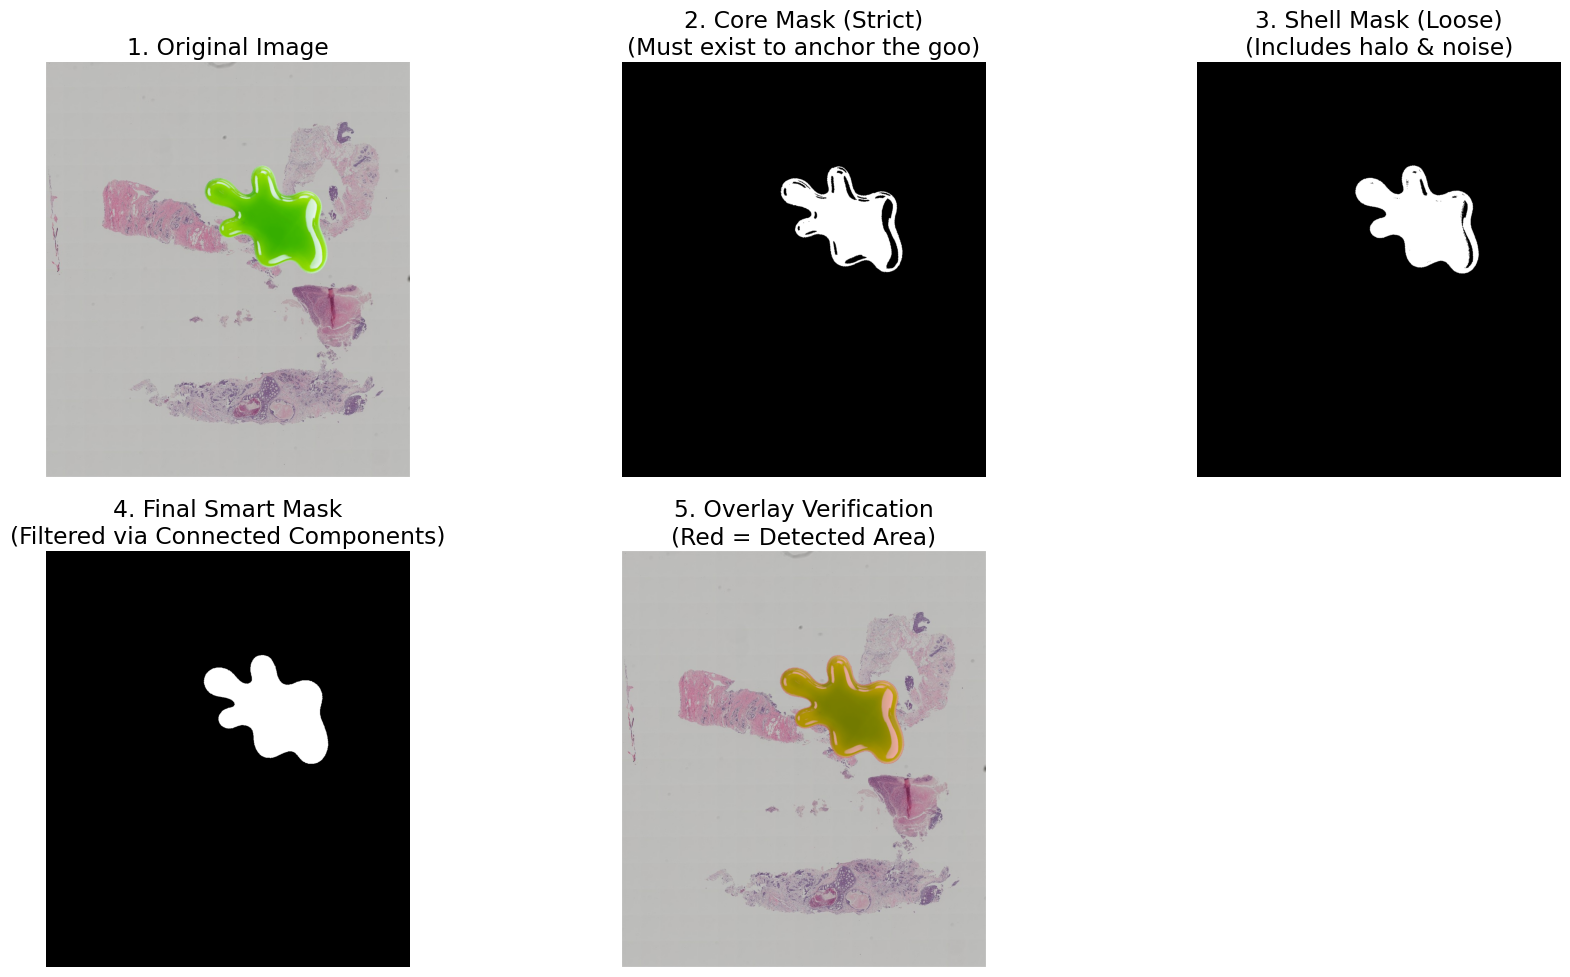

In [76]:
# Step 1: Remove goo and do not resize images
remove_goo(SOURCE_FOLDER,GOO_REMOVAL_OUT, target_size=None, remove_goo=True, save_masks=True, replacement_color=(195, 195, 195))
SAMPLE_IMG_GOO = os.path.join(SOURCE_FOLDER, 'img_0012.png')  # Sample image path
img = cv2.imread(SAMPLE_IMG_GOO)
visualize_smart_goo_results(img)

In [77]:
clean_and_save_masks(
    goo_masks_dir=os.path.join(GOO_REMOVAL_OUT, "goo_masks"), 
    external_masks_dir=SOURCE_FOLDER, 
    output_dir=os.path.join(GOO_REMOVAL_OUT, "cleaned_masks"), 
    target_size=None
)

Found 691 goo masks. Checking for existing and processing new masks...


Cleaning External Masks: 100%|██████████| 691/691 [00:00<00:00, 103483.56it/s]


Processing complete.
  - Cleaned and saved: 0 masks to ../../an2dl2526c2/preprocessing_results/train_nogoo/cleaned_masks
  - Skipped: 691 masks that already existed.


### Step 2: “Shrek” filtering (remove overly-green images)

This block estimates a **green-pixel ratio** for each image and splits the dataset:

- `ratio > ratio_threshold` → **Shrek**
- `ratio ≤ ratio_threshold` → **Tissue**

Then:
- `process_classification_results()` copies images into `SHREKS_OUT` and `TISSUE_OUT`
- `copy_masks()` copies the corresponding `mask_*` files for the kept tissue images




In [78]:
#Step 2: Discard Shrek Images
shreks_list, tissue_list = analyze_dataset_for_shreks(GOO_REMOVAL_OUT, shrek_dir=SHREKS_OUT, ratio_threshold=0.0125, expected_count=150)

process_classification_results(shreks_list, tissue_list, SHREKS_OUT, TISSUE_OUT, 0.0125, visualize=False)

tissue_image_names = [item['name'] for item in tissue_list]
copy_masks(tissue_image_names, SOURCE_FOLDER, TISSUE_OUT)

# Clean up memory
del shreks_list
del tissue_list
gc.collect()

Found 691 images in '../../an2dl2526c2/preprocessing_results/train_nogoo'. Analyzing for 'Shreks'...


Analyzing for Shreks: 100%|██████████| 691/691 [00:35<00:00, 19.36it/s] 


Classified 60 as Shrek
Classified 631 as Tissue
Saving 60 Shrek images to ../../an2dl2526c2/preprocessing_results/train_noshreks/train_shreks...


Saving Shrek Images: 100%|██████████| 60/60 [00:00<00:00, 105120.40it/s]


Saving 631 Tissue images to ../../an2dl2526c2/preprocessing_results/train_noshreks/train_tissue...


Saving Tissue Images: 100%|██████████| 631/631 [00:00<00:00, 219253.24it/s]


Shrek removal visulization OFF.


Copying Masks: 100%|██████████| 631/631 [00:00<00:00, 3801.93it/s]


60969

--- Grid View: 8 Random Samples ---


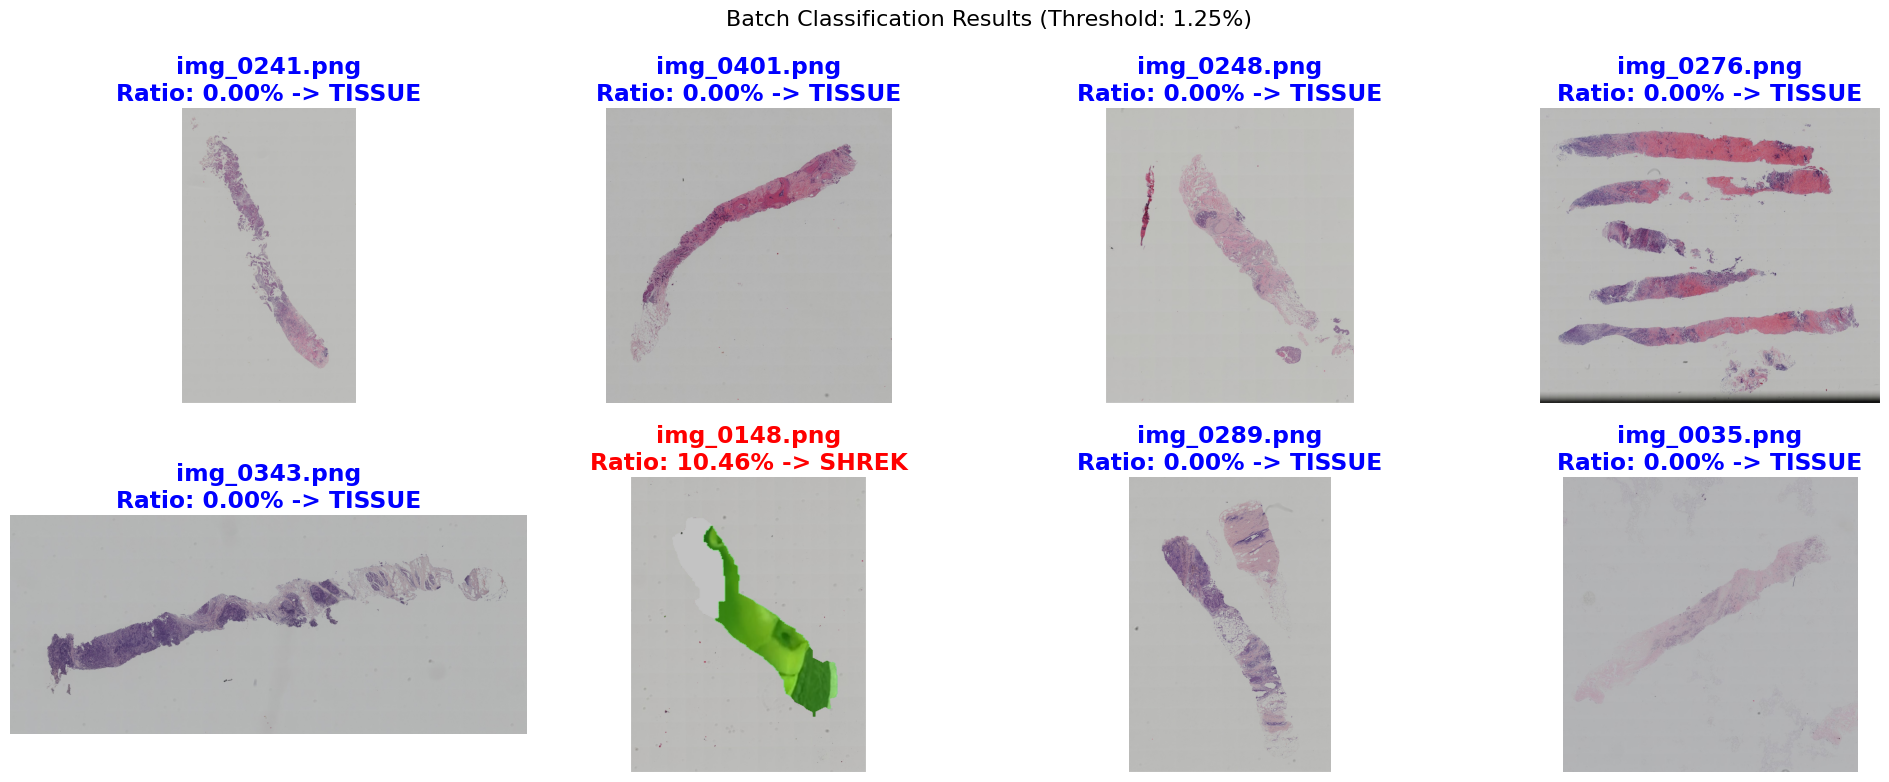

In [86]:
visualize_shrek_grid(GOO_REMOVAL_OUT, num_images=8, threshold=0.0125, random_seed=np.random.randint(0, 10000))

### Step 3: Patch extraction (train/tissue set)

`create_patches_dataset()` builds a patch-level dataset from the filtered “tissue” images:

- **Input images**: `TISSUE_OUT`
- **Input masks**: `CLEANED_MASKS_DIR` (often `GOO_REMOVAL_OUT/cleaned_masks`)
- **Outputs**:
  - patch images → `PATCHES_OUT/`
  - patch masks → `PATCHES_OUT/masks/`

Patch volume is controlled by `patch_size`, `stride`, `max_patches_per_blob`, `iou_thresh`, and `dilate_iterations`.


In [80]:
CLEANED_MASKS_DIR = os.path.join(GOO_REMOVAL_OUT, "cleaned_masks")

create_patches_dataset(
    TISSUE_OUT, 
    PATCHES_OUT, 
    mask_dir=CLEANED_MASKS_DIR,
    patch_size=224, 
    stride=224, 
    threshold=0.01,
    max_patches_per_blob=10,
    iou_thresh=0.5,
    dilate_iterations=15
)

Starting patch extraction from ../../an2dl2526c2/preprocessing_results/train_noshreks/train_tissue to ../../an2dl2526c2/preprocessing_results/train_patches...
Found 631 source images.


Processing Images: 100%|██████████| 631/631 [00:00<00:00, 1178.06it/s]


--- Extraction Summary ---
Images Processed: 0
Images Skipped:   631
Total Patches Saved in this run: 0
Patches are located in: ../../an2dl2526c2/preprocessing_results/train_patches
Mask patches are located in: ../../an2dl2526c2/preprocessing_results/train_patches/masks


### Step 4: Patch-level post-processing (blur and/or masking)

This cell contains two optional post-processing operations on the extracted patches:

1) **Background blurring** (`apply_blur_batch`)  
   - Keeps pixels where the mask is 255 and blurs the complement.  
   - **Assumption:** the mask filename matches the image filename. 

2) **Hard masking** (`apply_patch_masks_to_images`)  
   - Replaces the name mapping explicitly (`img_...` → `mask_...`) and writes masked patches to the configured output folder.


In [81]:
os.makedirs(BLURRED_OUT, exist_ok=True)
apply_blur_batch(
    images_dir=PATCHES_OUT, 
    masks_dir=os.path.join(PATCHES_OUT, "masks"), 
    output_dir=BLURRED_OUT, 
    blur_strength=(51, 51)
)


apply_patch_masks_to_images(PATCHES_OUT, output_dir=PATCHES_OUT_MASKED)

Found 3097 images to process.


Applying mask patches: 100%|██████████| 3097/3097 [00:00<00:00, 99181.94it/s]

Applied masks to 0 patches. Skipped 3097 existing outputs. Results in: ../../an2dl2526c2/preprocessing_results/train_patches_masked


## **3.2 Preprocess the Submission Set**

This section mirrors the train pipeline, but applied to the *submission/test* images.

Skips goo removal and shrek removal since the submission set is clean in that respect

In [82]:

create_patches_dataset(
    SUBMISSION_SOURCE_FOLDER, 
    SUBMISSION_PATCHES_OUT, 
    mask_dir=SUBMISSION_SOURCE_FOLDER,
    patch_size=224, 
    stride=224, 
    threshold=0.01,
    max_patches_per_blob=10,
    iou_thresh=0.5,
    dilate_iterations=15
)



Starting patch extraction from ../../an2dl2526c2/test_data to ../../an2dl2526c2/preprocessing_results/submission_patches...
Found 477 source images.


Processing Images: 100%|██████████| 477/477 [00:00<00:00, 1589.31it/s]



--- Extraction Summary ---
Images Processed: 0
Images Skipped:   477
Total Patches Saved in this run: 0
Patches are located in: ../../an2dl2526c2/preprocessing_results/submission_patches
Mask patches are located in: ../../an2dl2526c2/preprocessing_results/submission_patches/masks


In [83]:
apply_blur_batch(
    images_dir=SUBMISSION_PATCHES_OUT, 
    masks_dir=os.path.join(SUBMISSION_PATCHES_OUT, "masks"), 
    output_dir=SUBMISSION_BLURRED_OUT, 
    blur_strength=(51, 51)
)

apply_patch_masks_to_images(SUBMISSION_PATCHES_OUT, output_dir=SUBMISSION_PATCHES_OUT_MASKED)

Found 2301 images to process.


Applying mask patches: 100%|██████████| 2301/2301 [00:00<00:00, 106101.44it/s]

Applied masks to 0 patches. Skipped 2301 existing outputs. Results in: ../../an2dl2526c2/preprocessing_results/submission_patches_masked
